In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

import numpy as np
import pandas as pd

import logging

from ihrem.timeslice import ms
from ihrem import paths
from ihrem.analysis import video as vid
from ihrem.analysis import stim

from ihrem import traces as tr

from ihrem.figs_cpg import fig1, edf3


import warnings


warnings.simplefilter(action='error', category=FutureWarning)
pd.set_option('mode.chained_assignment','raise')
logging.basicConfig(level=logging.WARNING)


reg_full = paths.Registry.read_excel()

In [3]:
reg_sel = reg_full.sel_mask([
        'GL1380_20230724_sleep',
        'GL1380_20230727_sleep',
        'GL1380_20230726_sleep',
        'GL1380_20230807_sleep',
])

exp_light_wins = stim.load_light_wins_multi(reg_sel)

analysis_win_length = ms(minutes=12)

analysis_windows_pulses = stim.collect_analysis_windows(
    reg_sel,
    pulse_len=(0, ms(minutes=4)),
    win_len=analysis_win_length,
)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Found 44 pulses in total


# EDF 3a: EMG

In [4]:
pulse_emg = edf3.load_all_emg_traces(reg_sel, analysis_windows_pulses, channels=[0])

exp:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [5]:
%%time

analysis_windows_awake = edf3.collect_awake_analysis_windows(
    reg_sel,
    exp_light_wins,
    win_len=analysis_win_length,
)

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 1.29 s, sys: 168 ms, total: 1.46 s
Wall time: 2.21 s


In [6]:
%%time

awake_emg = edf3.load_all_emg_traces(reg_sel, analysis_windows_awake, channels=[0])

exp:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

CPU times: user 5.64 s, sys: 4.94 s, total: 10.6 s
Wall time: 11.3 s


In [7]:
awake_emg = tr.Traces(awake_emg.reg, awake_emg.traces)
pulse_emg = tr.Traces(pulse_emg.reg, pulse_emg.traces)

In [8]:

pulse_rect = edf3.get_emg_rectified(pulse_emg)
awake_rect = edf3.get_emg_rectified(awake_emg)

In [9]:


pulse_int = edf3.get_emg_integral(pulse_rect)
awake_int = edf3.get_emg_integral(awake_rect)

In [10]:
pre_pulse_int = pulse_int.crop((-np.inf, 0))
pos_pulse_int = pulse_int.crop((0, +np.inf))
awake_int_half = awake_int.crop((analysis_win_length * -.25, analysis_win_length * +.25))


pre_pulse_int['summary'] = pre_pulse_int.mean()
pos_pulse_int['summary'] = pos_pulse_int.mean()
awake_int_half['summary'] = awake_int_half.mean()

In [11]:
stats = edf3.extract_emg_stats(reg_sel, pre_pulse_int, pos_pulse_int, awake_int_half)


  0%|          | 0/4 [00:00<?, ?it/s]

Saving: /gpfs/laur/data/fenkl/from_luis/fig1/stats/emg_int.pdf


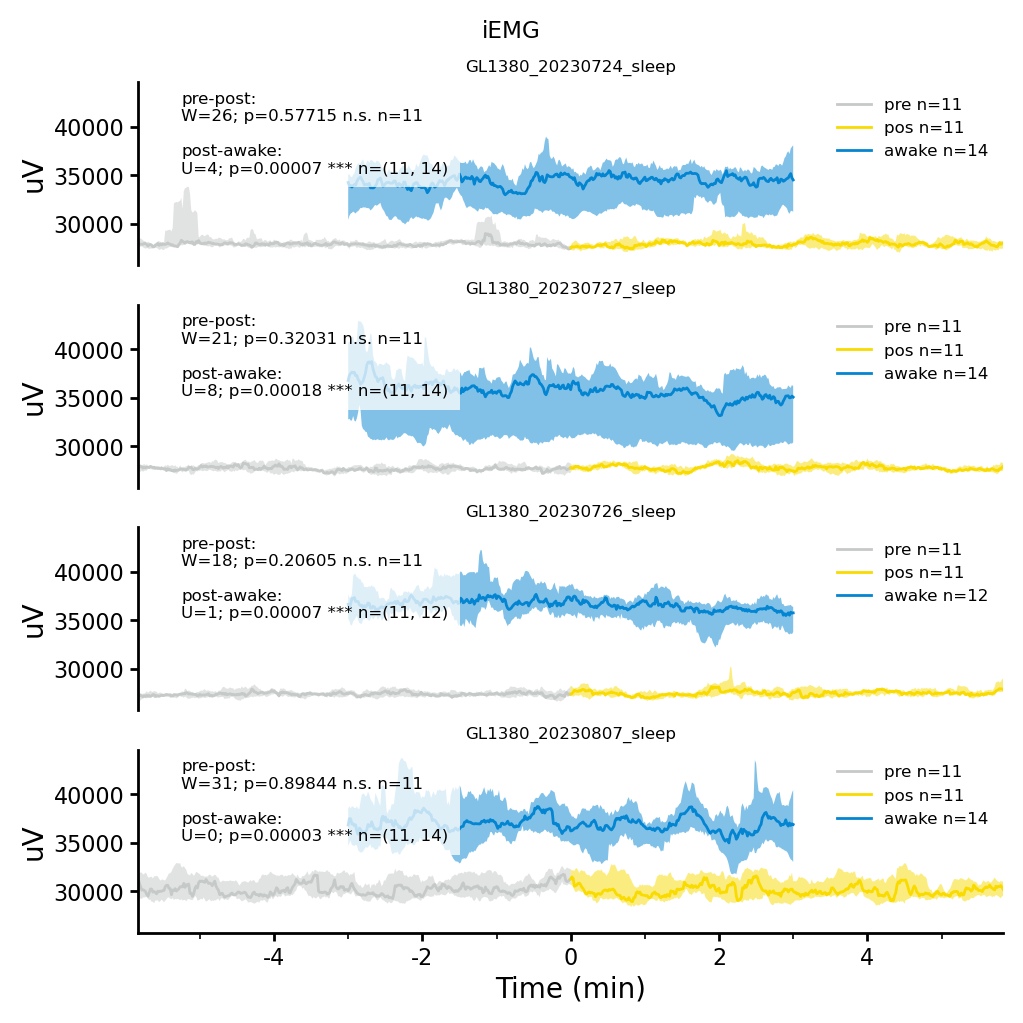

In [12]:
f = edf3.plot_emg(
    pre_pulse_int.downsample(1_000),
    pos_pulse_int.downsample(1_000),
    awake_int_half.downsample(1_000),
    suptitle=f'iEMG',
    stats=stats,
    exps=[
        'GL1380_20230724_sleep',
        'GL1380_20230727_sleep',
        'GL1380_20230726_sleep',
        'GL1380_20230807_sleep',
    ]
)
fig1.savefig(f, 'stats/emg_int')

# EDF 3b: eye-lid distance

In [13]:
reg_sel = reg_full.sel_mask([
    'GL1062_20210204',
    'GL1076_20210502',
    'GL1076_20210505',
])


reg_sel['dlc_path'] = reg_sel.collect_paths_deeplabcut()
reg_sel['has_dlc'] = reg_sel['dlc_path'].notna()
assert reg_sel['has_dlc'].all()

reg_sel.value_counts(['has_dlc', 'state', 'stim']).unstack('has_dlc', fill_value=0)

find:   0%|          | 0/3 [00:00<?, ?it/s]

has_dlc             True
state stim              
sleep light pulses     3

In [14]:
%%time

exp_dlc = vid.load_deeplabcut_multi(reg_sel['dlc_path'])
exp_dlc = vid.adjust_deeplabcut_time_multi(reg_sel, exp_dlc)

exp_eyes = vid.extract_eye_open_multi(exp_dlc)

exp_eyes.traces.interpolate(inplace=True, limit_area='inside')

exp_eyes

load:   0%|          | 0/3 [00:00<?, ?it/s]

adjust:   0%|          | 0/3 [00:00<?, ?it/s]

GL1062_20210204 time adjusted by 477.77 ms
GL1076_20210502 time adjusted by 525.86 ms
GL1076_20210505 time adjusted by 579.08 ms
CPU times: user 56.6 s, sys: 11.3 s, total: 1min 7s
Wall time: 1min 8s


In [15]:
analysis_windows = stim.collect_analysis_windows(reg_sel, pulse_len=(0, ms(minutes=4)), win_len=ms(minutes=6))

pulse_counts = analysis_windows.value_counts('exp_name')

analysis_windows = analysis_windows.sel_isin(
    exp_name=pulse_counts.index[pulse_counts > 8]
)

reg_sel = reg_sel.sel_mask(analysis_windows['exp_name'].unique())

  0%|          | 0/3 [00:00<?, ?it/s]

Found 33 pulses in total


In [16]:
eyes_cut = exp_eyes.cut_merge(analysis_windows)

  0%|          | 0/3 [00:00<?, ?it/s]

Saving: /gpfs/laur/data/fenkl/from_luis/fig1/dlc/pulse_triggered_average.pdf


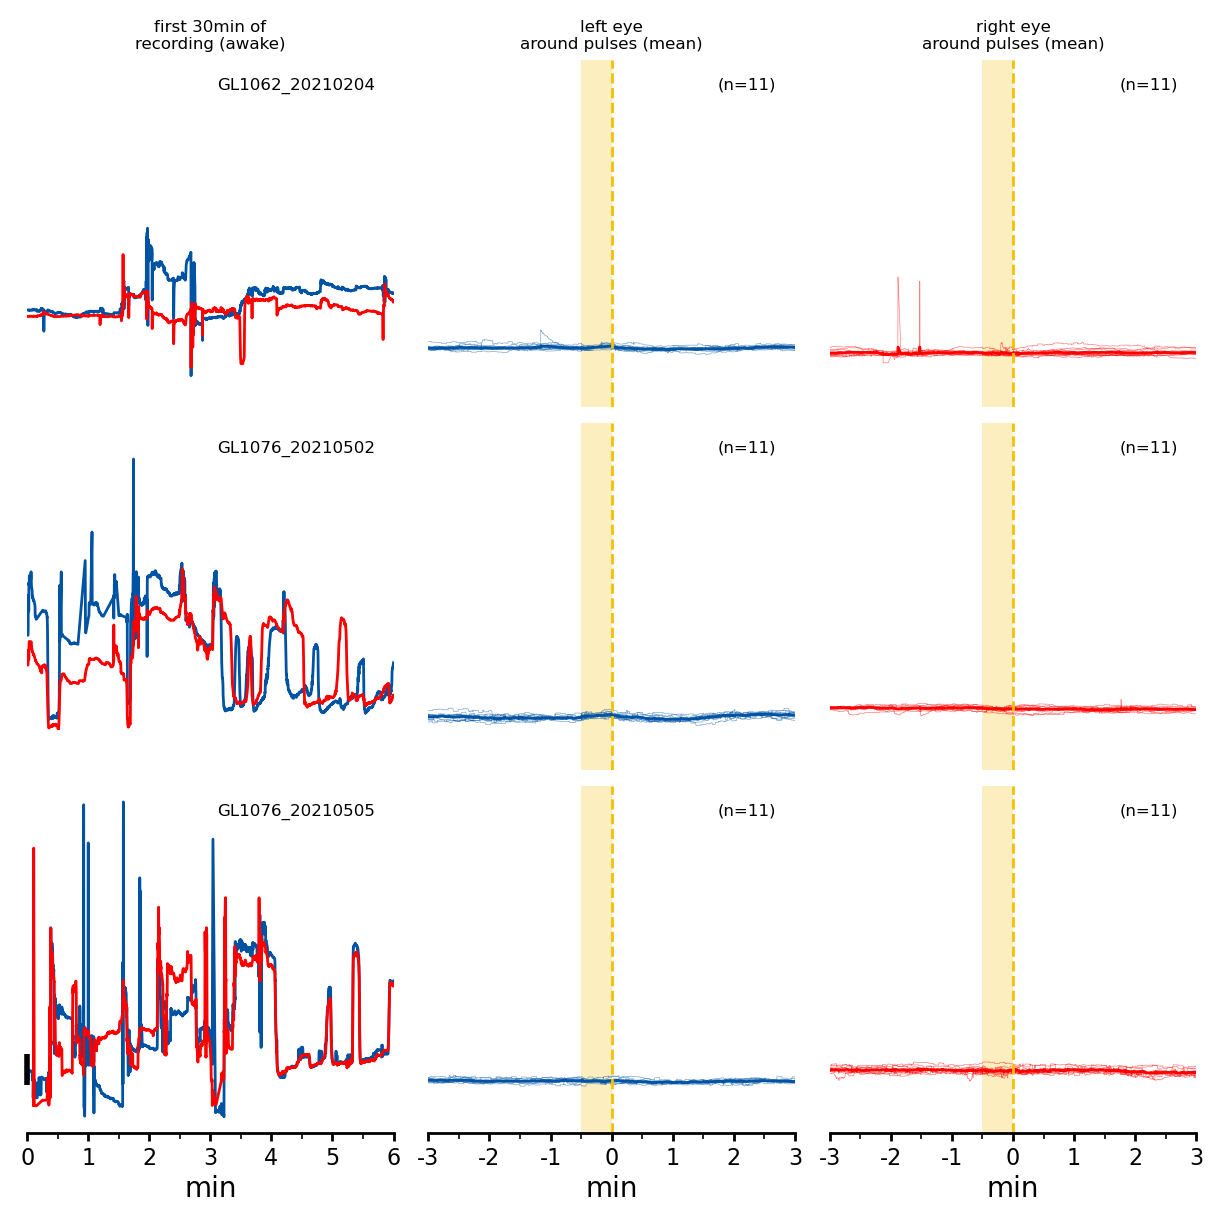

In [17]:
f = edf3.plot_dlc_vs_pulses(exp_eyes, eyes_cut, analysis_windows)

fig1.savefig(f, 'dlc/pulse_triggered_average')